In [1]:
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.utils.np_utils import to_categorical 
from keras.layers import Dense, Flatten
from keras.datasets import cifar10 # 10 farklı class
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json, codecs
from keras.models import load_model

# Transfer Learning'in Amacı Nedir?
- TL'nin amacı, daha önce oluşturulmuş, öğrenilmiş, transfer edilmiş weight değerleri eğitilmiş bir modeli kullanarak, yalnızca outputunu ya da full connected layerını train ederek, import edilerek yapılan bir yöntemdir.

## 1-Read Data

**cifar10** veriseti başarılı 0.5 oranlarında başarı oranı verecektir, bu yüzden epoch küçük tutulabilir. 

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print("x_train shape", x_train.shape)
print("train sample:", x_train.shape[0])
print("x_test shape", x_test.shape)
print("test sample:", x_test.shape[0])

x_train shape (50000, 32, 32, 3)
train sample: 50000
x_test shape (10000, 32, 32, 3)
test sample: 10000


## 2-Preprocessing

In [4]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [5]:
numberOfClass = len(np.unique(y_train))
numberOfClass

10

### A) Convert to Categorical Target Class

In [6]:
y_train = to_categorical(y_train, numberOfClass)
y_test = to_categorical(y_test, numberOfClass)

input_shape = x_train.shape[1:]

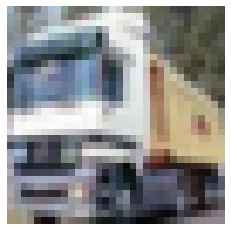

In [7]:
# visualize
plt.imshow(x_train[1].astype(np.uint8))
plt.axis("off")
plt.show()

### B) Increase Image Dimension
#### NOTE
- VGG19 modeli resimleri 48x48 boyutunda istediği için, 32x32'lik resimler 48x48 boyutlarına openCV ile dönüştürülür. 
- Aşağıda (i, :, :, :) => (i, 32, 32, 3) de yazabiliriz, hiçbir şey belirtmezsek ne varsa onu al demek.
- (48, 48) => 48x48'e dönüştürülecek demek.

In [8]:
def resize_img(img):
    numberOfImage = img.shape[0] # 50000 image for train
    new_array = np.zeros((numberOfImage, 48, 48, 3))
    for i in range(numberOfImage):
        new_array[i] = cv2.resize(img[i, :, :, :],(48, 48))
    return new_array

In [9]:
x_train = resize_img(x_train)
x_test = resize_img(x_test)
print("increased dimension of x_train:", x_train.shape)
print("increased dimension of x_test:", x_test.shape)

increased dimension of x_train: (50000, 48, 48, 3)
increased dimension of x_test: (10000, 48, 48, 3)


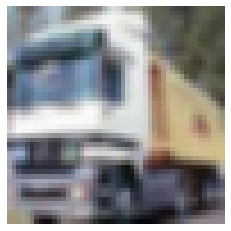

In [10]:
# visualize
plt.figure()
plt.imshow(x_train[1].astype(np.uint8))
plt.axis("off")
plt.show()

## 3-Create VGG19 Model
### A) Create vgg19 and custom model
#### NOTE
- This model consists of 19 layers(with output).
- ```weights = "imagenet"``` kodunun anlamı: **VGG19**, bir **transfer learning** modeli olduğu için, bu model bir yerde eğitilmiş. 
- Weightlerin eğitildiği yer ise, **imagenet dataseti** olsun diye belirtiyoruz.
- ```include_top = False``` => **full connected layerı(output)** eklememek için.

In [11]:
vgg = VGG19(include_top = False, weights = "imagenet", input_shape = (48, 48, 3))

In [12]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [13]:
vgg_layer_list = vgg.layers
vgg_layer_list

In [14]:
len(vgg_layer_list)

22

In [15]:
model = Sequential()
for layer in vgg_layer_list:
    model.add(layer)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

### B) Add Full Connected Layers to Model

#### NOTE
- Aşağıda modelin her bir layerı dolaşılır.
- Her bir layer dolaşılırken **train edilmesin** özelliği seçilir.
- Daha önceden **ImageNet** datası kullanılarak train edilmiş weightler kullanılacak.
- Yalnızca en son eklenecek layerın weightleri train edilecek.

In [17]:
for layer in model.layers:
    layer.trainable = False # full connected dışındakileri train etme sakın.

In [18]:
model.add(Flatten()) # 48x48
model.add(Dense(128)) # 128 Neron
model.add(Dense(numberOfClass, activation= "softmax")) # output=neron count=numberOfClass

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

### C) Compile Model

In [20]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

## 3-Train Data

### NOTE
- ```validation_split = 0.2``` Model train edilirken, validation verisi de çıkartılıyor.
- Bu validation datasetini x_train ve y_train içerisinden %20 olacak şekilde kendisi çıkartıyor.

In [21]:
hist = model.fit(x_train, y_train, validation_split = 0.2, epochs = 25, batch_size = 4096)

Epoch 1/25
10/10 [==============================] - 567s 58s/step - loss: 15.2457 - accuracy: 0.2828 - val_loss: 8.7390 - val_accuracy: 0.4003
Epoch 2/25
10/10 [==============================] - 542s 55s/step - loss: 7.6993 - accuracy: 0.4188 - val_loss: 6.6759 - val_accuracy: 0.4405
Epoch 3/25
10/10 [==============================] - 570s 58s/step - loss: 6.2419 - accuracy: 0.4569 - val_loss: 6.0387 - val_accuracy: 0.4782
Epoch 4/25
10/10 [==============================] - 543s 55s/step - loss: 5.6680 - accuracy: 0.4677 - val_loss: 4.7353 - val_accuracy: 0.4974
Epoch 5/25
10/10 [==============================] - 519s 53s/step - loss: 4.6112 - accuracy: 0.4994 - val_loss: 4.8256 - val_accuracy: 0.4871
Epoch 6/25
10/10 [==============================] - 518s 53s/step - loss: 4.3800 - accuracy: 0.5021 - val_loss: 6.0589 - val_accuracy: 0.4781
Epoch 7/25
10/10 [==============================] - 539s 55s/step - loss: 4.3157 - accuracy: 0.5093 - val_loss: 3.9392 - val_accuracy: 0.4804
Epoch

## 4-Save Model and History

In [22]:
model.save("vgg19_demo.h5")
with open("vgg19_demo.json", "w") as f:
    json.dump(hist.history, f)

## 5-Load Model and History

In [23]:
with codecs.open("vgg19_demo.json","r", encoding = "utf-8") as f:
    history1 = json.loads(f.read())
model1 = load_model("vgg19_demo.h5")

In [24]:
history1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## 6-Evaluation Model

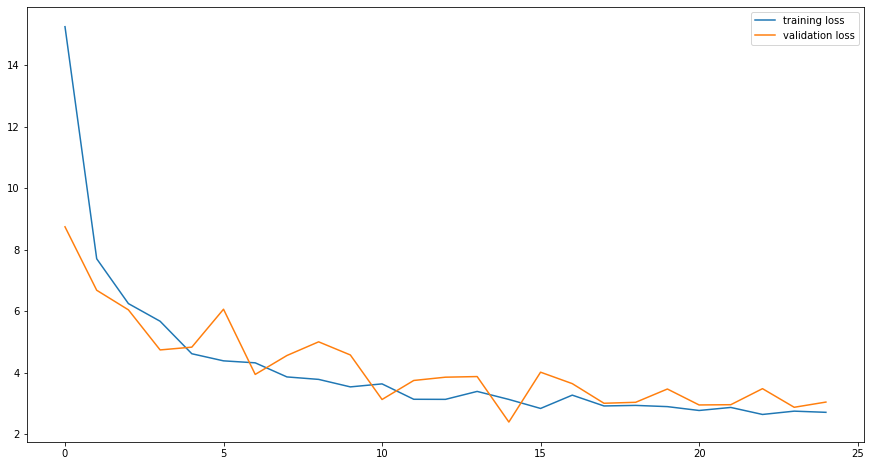

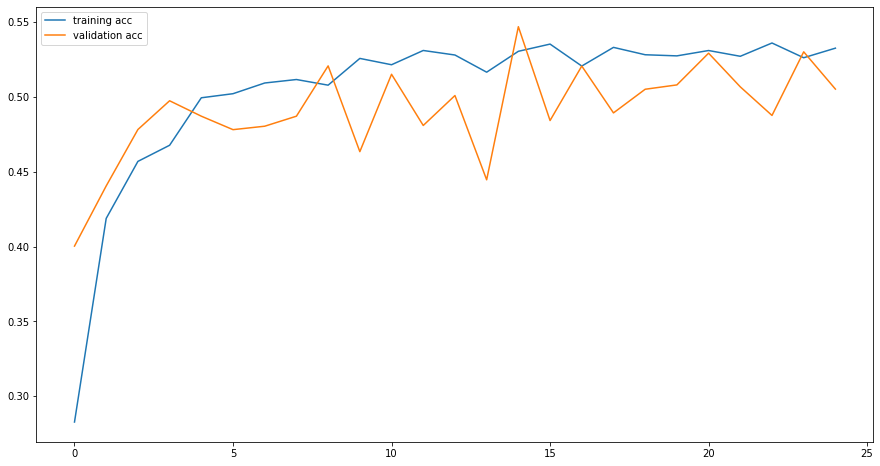

In [25]:
plt.figure(figsize = (15, 8))
plt.plot(history1["loss"], label = "training loss")
plt.plot(history1["val_loss"], label = "validation loss")
plt.legend()
plt.show()
plt.figure(figsize = (15, 8))
plt.plot(history1["accuracy"], label = "training acc")
plt.plot(history1["val_accuracy"], label = "validation acc")
plt.legend()
plt.show()